# Compare BLISS and Photo Catalog against DECaLS on SDSS image

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from os import environ
import torch
import numpy as np
import pandas as pd
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt

from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.encoder import Encoder
from bliss.surveys.sdss import PhotoFullCatalog, SloanDigitalSkySurvey
from bliss.surveys.decals import DecalsFullCatalog
from bliss.predict import align
from bliss.plotting import plot_plocs
from bliss.metrics import BlissMetrics, MetricsMode, three_way_matching

In [3]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

## Load model and data

In [4]:
model: Encoder = instantiate(cfg.encoder)
model.load_state_dict(torch.load("../../data/pretrained_models/psf_aware.pt"))
model.eval();


                 from  n    params  module                                  arguments                     
  0                -1  1     14528  yolov5.models.common.Conv               [9, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

In [5]:
# load SDSS catalog, image and background, and WCS
run, camcol, field = 94, 1, 12
sdss = SloanDigitalSkySurvey("/data/sdss", run, camcol, (field,))
wcs = sdss[0]["wcs"]

image = align(sdss[0]['image'], wcs)[None]
background = align(sdss[0]['background'], wcs)[None]

# crop to center, ensure dims are multiples of 16
_, _, height, width = image.shape
min_h, min_w = (height // 64) * 16, (width // 64) * 16
max_h, max_w = min_h * 3, min_w * 3
cropped_image = image[:, :, min_h:max_h, min_w:max_w]
cropped_background = background[:, :, min_h:max_h, min_w:max_w]

### Load PSF and use to deconvolve image

In [6]:
simulator = instantiate(cfg.simulator)
decoder = simulator.image_decoder

psfs = [decoder.psf_galsim[(run, camcol, field)]]
psf_params = decoder.psf_params[(run, camcol, field)][None]

deconv = simulator.get_deconvolved_images(cropped_image, cropped_background, psfs)

### Load Photo and DECaLS catalogs based on SDSS image

In [7]:
crop_px = model.tiles_to_crop * model.tile_slen
ra_lim, dec_lim = wcs[2].all_pix2world((min_w + crop_px, max_w - crop_px), (min_h + crop_px, max_h - crop_px), 0)  # don't include areas that will be cropped

photo_cat = PhotoFullCatalog.from_file(
    cfg.paths.sdss,
    run=run, camcol=camcol, field=field, sdss_obj=sdss
).restrict_by_ra_dec(ra_lim, dec_lim)

decals_path = Path(cfg.paths.decals) / "tractor-3366m010.fits"
decals_cat = DecalsFullCatalog.from_file(decals_path, ra_lim, dec_lim, wcs=wcs[2])

## Make predictions

In [8]:
batch = {
    "images": torch.from_numpy(cropped_image).float(),
    "background": torch.from_numpy(cropped_background).float(),
    "deconvolution": deconv.float(),
    "psf_params": psf_params.float()
}

In [9]:
with torch.no_grad():
    x_cat_marginal, _ = encoder.get_marginal(batch)
    pred = encoder.get_predicted_dist(x_cat_marginal)
    bliss_cat = model.variational_mode(pred)

# adjust locations to account for cropped tiles and cropped image
bliss_cat.plocs = bliss_cat.plocs + torch.tensor([crop_px + min_h, crop_px + min_w])

In [10]:
print(f"{bliss_cat.n_sources.item()} light sources predicted by bliss")
print(f"{photo_cat.n_sources.item()} light sources in PhotoCatalog")
print(f"{decals_cat.n_sources.item()} light sources in DECaLS catalog")

282 light sources predicted by bliss
193 light sources in PhotoCatalog
1287 light sources in DECaLS catalog


### Plot predictions

In [16]:
# compare bliss and photo against union of detectable sources in decals
matches = three_way_matching(bliss_cat, photo_cat, decals_cat, slack=2)

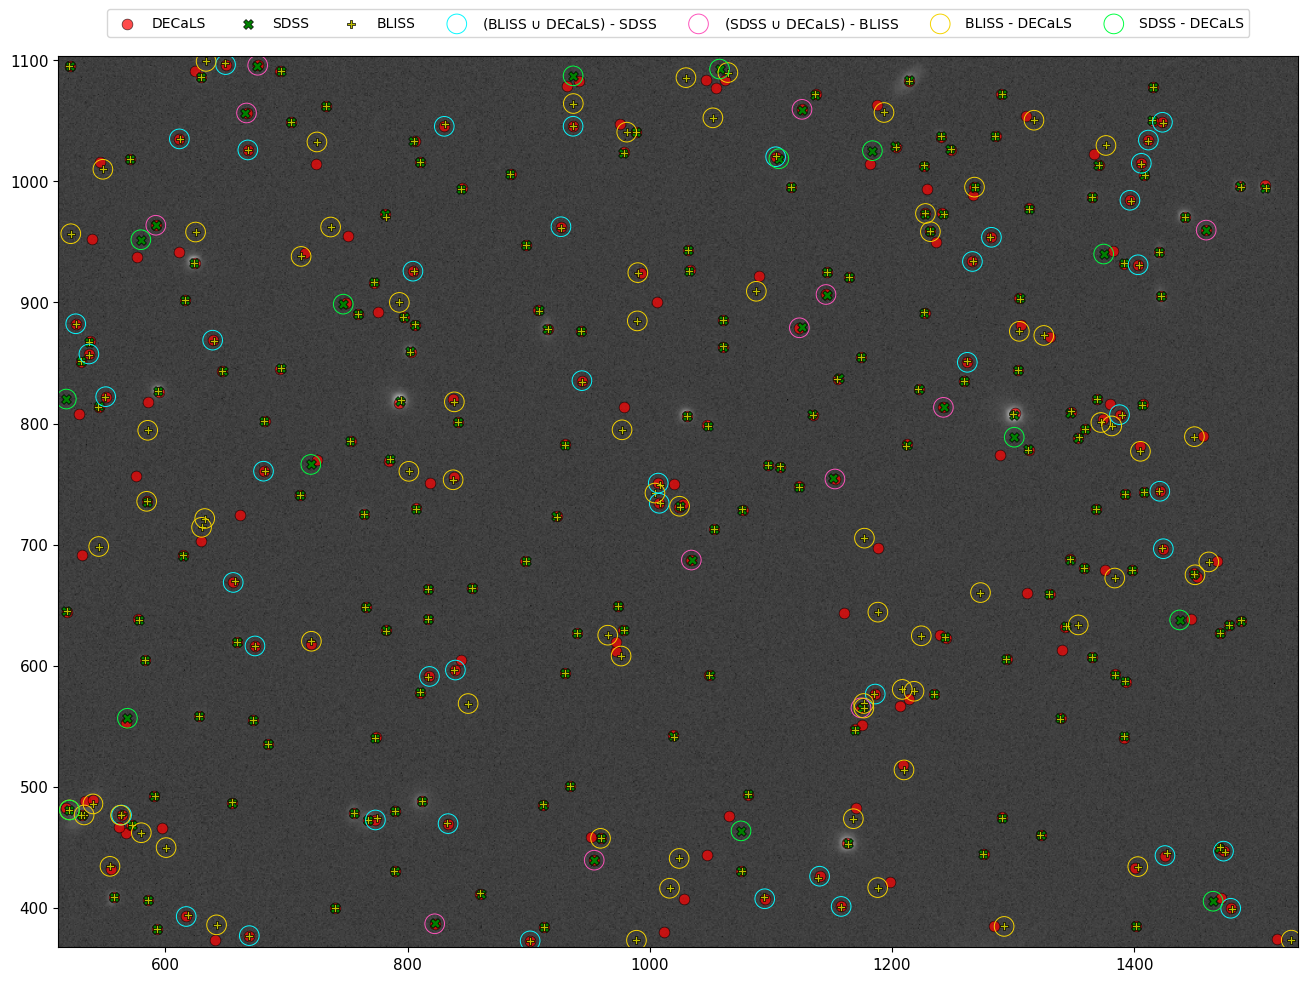

In [52]:
fig, ax = plt.subplots(figsize=(16, 12))
extent = np.array([min_w, max_w, min_h, max_h]) - 0.5
ax.imshow(np.log(cropped_image[0, 2] - cropped_image[0, 2].min() + 20), cmap="gray", extent=extent, origin="lower")

plot_plocs(decals_cat, ax, 0, list(matches["gt_all"]), color="r", marker="o", s=60, edgecolor="black", alpha=0.7, linewidth=0.5, label="DECaLS")
plot_plocs(photo_cat, ax, 0, "all", color="g", marker="X", s=50, edgecolor="black", linewidth=0.5, label="SDSS")
plot_plocs(bliss_cat, ax, 0, "all", color="y", marker="P", s=30, edgecolor="black", linewidth=0.5, label="BLISS")

params = {
    "marker": MarkerStyle("o", fillstyle="none"),
    "s": 200,
    "linewidth": 0.7,
}
colors = [
    '#08F7FE',  # cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]
#plot_plocs(decals_cat, ax, 0, matches["all"], c=colors[0], label="all", **params)
plot_plocs(decals_cat, ax, 0, list(matches["gt_pred_only"]), c=colors[0], label=r"(BLISS $\cup$ DECaLS) - SDSS", **params)
plot_plocs(decals_cat, ax, 0, list(matches["gt_comp_only"]), c=colors[1], label=r"(SDSS $\cup$ DECaLS) - BLISS", **params)
plot_plocs(bliss_cat, ax, 0, list(matches["pred_only"]), c=colors[2], label=r"BLISS - DECaLS", **params)
plot_plocs(photo_cat, ax, 0, list(matches["comp_only"]), c=colors[3], label=r"SDSS - DECaLS", **params)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="upper center", ncol=7, bbox_to_anchor=(0.0, 0.06, 1, 1), fontsize=10)

The sources circled in light blue are BLISS predictions that match a source in DECaLS, but are not present in SDSS. Conversely, the light purple circles indicate sources present in SDSS and DECaLS but not predicted by BLISS. Yellow circles are false positives predicted by BLISS, and green circles denote false positives in SDSS.

## 3-way metrics computation

In [18]:
metrics = BlissMetrics(mode=MetricsMode.FULL, slack=3)
bliss_metrics = metrics(decals_cat, bliss_cat)
photo_metrics = metrics(decals_cat, photo_cat)

df = pd.DataFrame.from_dict({"bliss": bliss_metrics, "sdss": photo_metrics}, orient="index")
df

,detection_precision,detection_recall,f1,avg_distance,avg_keep_distance,gal_tp,gal_fp,star_tp,star_fp,class_acc
bliss,0.776596,0.170163,0.279159,3.449214,0.622438,112.0,14.0,64.0,29.0,0.803653
sdss,0.932642,0.139860,0.243243,1.003758,0.443856,73.0,21.0,74.0,12.0,0.816667
